In [1]:
import numpy as np 
import cv2
import pandas as pd
import glob

In [2]:
project_folder = "./data/datasets/final_project_dataset"
rgb_dir = f"{project_folder}/crazyflie-rgb-images"
pose_dir = f"{project_folder}/crazyflie-poses"

fx = 218.792814876677
fy = 224.37416225752526
cx = 322.66660990415625
cy = 243.22672826370496

In [3]:

rgb_files = sorted(glob.glob(f"{rgb_dir}/*.jpg"))
pose_files = sorted(glob.glob(f"{pose_dir}/*.txt"))
df = pd.DataFrame({
    "rgb_path": rgb_files,     # stores the actual path
    "pose_path": pose_files
})
df.head()

,rgb_path,pose_path
0,./data/datasets/final_project_dataset/crazyfli...,./data/datasets/final_project_dataset/crazyfli...
1,./data/datasets/final_project_dataset/crazyfli...,./data/datasets/final_project_dataset/crazyfli...
2,./data/datasets/final_project_dataset/crazyfli...,./data/datasets/final_project_dataset/crazyfli...
3,./data/datasets/final_project_dataset/crazyfli...,./data/datasets/final_project_dataset/crazyfli...
4,./data/datasets/final_project_dataset/crazyfli...,./data/datasets/final_project_dataset/crazyfli...


In [4]:
# You can visualize the rgb images here:

def show_img(path):
    return f"<img src='{path}' width='300'/>"

styled = df.head(2).style.format({
    "rgb_path": show_img     # render image instead of path
}).hide(axis="index")        # optional: hide row numbers

display(styled)

rgb_path,pose_path
,./data/datasets/final_project_dataset/crazyflie-poses/crazyflie_frame-001600.pose.txt
,./data/datasets/final_project_dataset/crazyflie-poses/crazyflie_frame-001601.pose.txt


## Set up model

### Zoe Depth setup

In [5]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "models/ZoeDepth")
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.utils.misc import get_image_from_url, colorize


# Device
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
conf = get_config("zoedepth", "eval")
model_zoe = build_model(conf)
zoe = model_zoe.to(DEVICE)
zoe.eval()

img_size [384, 512]


Using cache found in /Users/manoruo/.cache/torch/hub/intel-isl_MiDaS_master
/opt/homebrew/anaconda3/envs/RL/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


ZoeDepth(
  (core): MidasCore(
    (core): DPTDepthModel(
      (pretrained): Module(
        (model): Beit(
          (patch_embed): PatchEmbed(
            (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            (norm): Identity()
          )
          (pos_drop): Dropout(p=0.0, inplace=False)
          (blocks): ModuleList(
            (0-23): 24 x Block(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=1024, out_features=3072, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=1024, out_features=1024, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

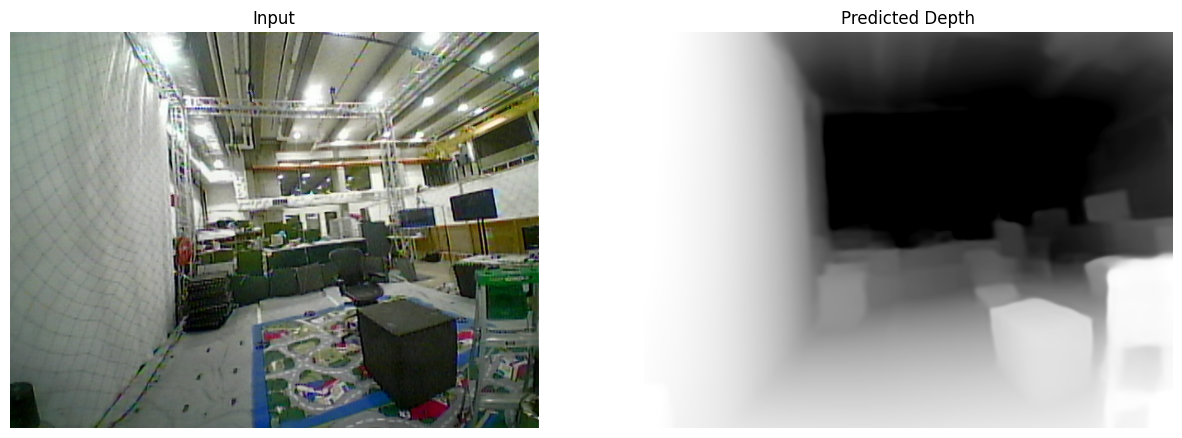

In [6]:

img = Image.open("data/datasets/final_project_dataset/crazyflie-rgb-images/crazyflie_frame-001674.rgb.jpg")
# Run ZoeDepth
depth_numpy = zoe.infer_pil(img)

# Colorize depth for visualization
colored_depth = colorize(depth_numpy)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(title)
plt.show()


In [ ]:
import open3d as o3d

def back_project(fx, fy, depth, cx, cy):
    H, W = depth.shape

    u, v = np.meshgrid(np.arange(W), np.arange(H))

    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth

    return np.stack((x, y, z), axis=-1)   # HxWx3


def make_o3d_pointcloud(rgb_path, depth_path, fx, fy, cx, cy):
    
    if type(rgb_path) != str:
        rgb = rgb_path
    else:
        rgb = cv2.imread(rgb_path)[:, :, ::-1]
    
    if type(depth_path) != str:
        depth = depth_path
    else:
        depth = np.load(depth_path).astype(np.float32) / 1000 ## convert mm depth map to meter

    # ----- CREATE MASK -----
    mask = (depth > 0) & np.isfinite(depth)   # boolean mask HxW

    # Unproject entire depth → xyz
    xyz = back_project(fx, fy, depth, cx, cy)   # HxW x 3

    # Flatten arrays
    xyz_flat = xyz.reshape(-1, 3)
    rgb_flat = rgb.reshape(-1, 3)
    mask_flat = mask.reshape(-1)

    # Apply mask
    xyz_valid = xyz_flat[mask_flat]
    rgb_valid = rgb_flat[mask_flat] / 255.0

    # Build point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz_valid)
    pcd.colors = o3d.utility.Vector3dVector(rgb_valid)

    return pcd


: 

In [ ]:

pcd = make_o3d_pointcloud(np.array(img), depth_numpy, fx, fy, cx, cy).voxel_down_sample(voxel_size=0.02)

cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
clean_pcd = pcd.select_by_index(ind)

o3d.visualization.draw_geometries([clean_pcd])